# Advanced Certification in AIML
## A Program by IIIT-H and TalentSprint

## Problem Statement

Denoise the leaf images using deep learning techniques

## Learning Objectives

At the end of the Mini Hackathon, you will be able to :
* Denoise healthy/diseased leaf images using Autoencoder
* Visualize the denoised images

## Background

Crop losses due to diseases are a major threat to food security every year, across countries.  Conventionally, plant diseases were detected through a visual examination of the affected plants by plant pathology experts. This was often possible only after major damage had already occurred, so treatments were of limited or no use. Recently, access to smartphone based image capturing has highly increased amongst farmers and agriculturists. This has led to the successful adoption of plant disease diagnostic applications based on deep learning techniques. This is of immense value in the field of agriculture and an excellent tool for faster identification and treatment of crop diseases. It holds key importance in preventing crop based food and economic losses. 
## Dataset and Methodology

The dataset for this Mini-Hackathon is derived from the 'Plant Village' Dataset.Around 4500 images of healthy and diseased leaves and their labels have been taken from the 'Plant Village' Dataset. The 4500 images consist of 5 different classes - Bell Pepper Healthy, Bell Pepper Bacterial Spot, Potato Healthy, Potato Early Blight and Potato Late Blight. The original pictures have been clicked in a well controlled environment with very less noise in the images. This is not how real world data may look like.  So we have added noise to the original images to form a noisy dataset. We can use deep learning techniques such as an autoencoder for obtaining denoised images. 


## References:

[Plant Village Dataset Description](https://drive.google.com/file/d/1xGhK-KhhE8W_lfr3l6KT_9K8prHDRb9_/view?usp=sharing)


[Deep Learning for Plant Disease Detection](https://drive.google.com/file/d/1V7NgFs-YGG3G-pz3OJf2X-KQxOGRZzRu/view?usp=sharing)

[Denoising Autoencoder motivational expt](https://drive.google.com/file/d/1Sm1CDAhXDVlv9nFEjFMeYJ9eIwvoQIIZ/view?usp=sharing)


## Grading = 20 Marks

## Setup Steps

In [ ]:
! wget https://cdn.iiith.talentsprint.com/aiml/Experiment_related_data/PlantVillage_Noisy_Dataset.zip
! unzip -qq PlantVillage_Noisy_Dataset.zip

**Import Libraries**

In [ ]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.autograd import Variable

## **Stage 1:** Data Preparation

### 2 Marks - > Prepare the dataset

1. Define transformations:
   * Transform image size to 128 by using Resize()
   * Transform the image into a number using tensor)
2. Load the dataset with the defined transformations.

In [ ]:
# YOUR CODE HERE for the transforming the dataset
IMG_HEIGHT, IMG_WIDTH = 256,256

transforms = transforms.Compose([transforms.Resize((IMG_HEIGHT, IMG_WIDTH)), transforms.ToTensor()])

pure_train_data = datasets.ImageFolder('/content/PlantVillage/Pure_Dataset/Train_Data', transform = transforms)
pure_test_data = datasets.ImageFolder('/content/PlantVillage/Pure_Dataset/Test_Data', transform = transforms)
noisy_train_data = datasets.ImageFolder('/content/PlantVillage/Noisy_Dataset/Train_Data', transform = transforms)
noisy_test_data = datasets.ImageFolder('/content/PlantVillage/Noisy_Dataset/Test_Data', transform = transforms)

In [ ]:
pure_train_data.class_to_idx

{'Pepper__bell___Bacterial_spot': 0,
 'Pepper__bell___healthy': 1,
 'Potato___Early_blight': 2,
 'Potato___Late_blight': 3,
 'Potato___healthy': 4}

In [ ]:
# Check number of training and test images
dataset_sizes = {'Pure Train': len(pure_train_data), 'Pure Test': len(pure_test_data), 'Noisy Train': len(noisy_train_data), 'Noisy Test': len(noisy_test_data)}
dataset_sizes

{'Noisy Test': 1613,
 'Noisy Train': 3007,
 'Pure Test': 1613,
 'Pure Train': 3007}

In [ ]:
# YOUR CODE HERE for preparing trainloader and testloader set
batch_size = 40

pure_train_loader = torch.utils.data.DataLoader(pure_train_data, batch_size = batch_size)
pure_test_loader = torch.utils.data.DataLoader(pure_test_data, batch_size = batch_size)
noisy_train_loader = torch.utils.data.DataLoader(noisy_train_data, batch_size = batch_size)
noisy_test_loader = torch.utils.data.DataLoader(noisy_test_data, batch_size = batch_size)

In [ ]:
clean_img, label = next(iter(pure_train_loader))
clean_img.shape, label.shape

(torch.Size([40, 3, 256, 256]), torch.Size([40]))

In [ ]:
noisy_img, label = next(iter(noisy_train_loader))
noisy_img.shape, label.shape

(torch.Size([40, 3, 256, 256]), torch.Size([40]))

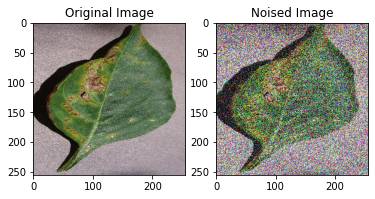

In [ ]:
f, axes=plt.subplots(1,2)

pure1stBatch_train, noise1stBatch_train = next(iter(zip(pure_train_loader, noisy_train_loader)))
pure_Train_Images, labels = pure1stBatch_train
noisy_Train_Images, _ = noise1stBatch_train

axes[0].imshow(pure_Train_Images[0].permute(1,2,0))
axes[0].set_title("Original Image")
axes[1].imshow(noisy_Train_Images[0].permute(1,2,0))
axes[1].set_title("Noised Image")
plt.show()

## **Stage 2:** Build and Train the Model



### 4 Marks -> Write the encoder and decoder layers in one class

* Define the Autoencoder neural network
    *  First define the layers required in the  __init__ function.
    *  Build the neural network in the forward() function.

[Hint for saving the images](https://debuggercafe.com/implementing-deep-autoencoder-in-pytorch/)

In [ ]:
# YOUR CODE HERE for constructing an autoencoder model

import os
from torchvision.utils import save_image

NUM_EPOCHS = 31
LEARNING_RATE = 1e-3 # 0.001

def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

def make_dir():
    image_dir = 'Saved_Images'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)

def save_decoded_image(img, name):
    img = img.view(3, IMG_HEIGHT, IMG_WIDTH)
    save_image(img, name)

make_dir()
device = get_device()
print(device)

cuda:0


In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # encoder
        self.enc1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3)
        self.enc2 = nn.Conv2d(in_channels=8, out_channels=4, kernel_size=3)

        # decoder 
        self.dec1 = nn.ConvTranspose2d(in_channels=4, out_channels=8, kernel_size=3)
        self.dec2 = nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=3)

    def forward(self, x):
       x = F.relu(self.enc1(x))
       x = F.relu(self.enc2(x))
       x = F.relu(self.dec1(x))
       x = F.relu(self.dec2(x))
       return x

net = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
net.to(device)
print(net)

Autoencoder(
  (enc1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (enc2): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1))
  (dec1): ConvTranspose2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (dec2): ConvTranspose2d(8, 3, kernel_size=(3, 3), stride=(1, 1))
)


### 4 Marks -> Train the Model and calculate the loss for dataset for each epoch.

1. Declare the loss function and optimizer
2. Create a directory for saving the output images.
2. Train the model
   *  Extract the image features only as we do not take the labels to train the autoencoder network.
   * Calculate the loss.
   * Append the loss values after every epoch and print them.
   * Save the output (denoised) images in a directory. 

In [ ]:
# YOUR CODE HERE for declaring the loss function and optimizer 

In [ ]:
# YOUR CODE HERE for defining a function for creating the directory 

In [ ]:
# YOUR CODE HERE. 

# Train the model and print the loss at each epoch. Also save the output (denoised) images in a directory. 

def train(net, puretrainloader, noisytrainloader, epochs):
    train_loss = []    
    for epoch in range(epochs):
        running_loss = 0.0
        for clean, dirty in zip(puretrainloader, noisytrainloader):
          clean_images, labels = clean
          noisy_images, _ = dirty
          noisy_images, clean_images = noisy_images.to(device), clean_images.to(device)
          #-----------------Forward Pass----------------------
          output = net(noisy_images)
          loss = criterion(output, clean_images)

          #-----------------Backward Pass---------------------
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          running_loss+=loss.item()

          if epoch == epochs-1:
            #print("Last Epoch")
            for i in range(len(noisy_images)):
                save_decoded_image(clean_images[i].cpu().data, name='./Saved_Images/clean{}.png'.format(i))
                save_decoded_image(noisy_images[i].cpu().data, name='./Saved_Images/noisy{}.png'.format(i))
                save_decoded_image(output[i].cpu().data, name='./Saved_Images/denoised{}.png'.format(i))
             #   print("saved_decoded_images")

        #-----------------Log-------------------------------
        loss = running_loss/len(puretrainloader)
        train_loss.append(loss)
        print("======> epoch: {}/{}, Loss:{}".format(epoch,epochs,loss))
        
    return train_loss, net

# YOUR CODE HERE 

# Record loss of the train denoised images
train_loss, net = train(net, pure_train_loader, noisy_train_loader, 5)

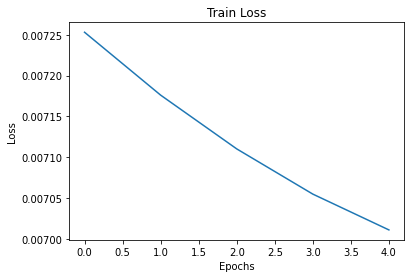

In [ ]:
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('conv_ae_loss.png')

## **Stage 3:** Visualize the Denoised images 

### 3 Marks -> Verify the denoised images and compare with original noisy images
1. Plot the original noisy images.
2. Plot denoised images which are saved in the directory.
3. Verify whether denoised images have less noise compared to original noisy images

**Hint:** If the noise is not reduced in the denoised images then revise the autoencoder architecture.

In [ ]:
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

def showImagesHorizontally(list_of_files):
    fig = figure(figsize=(20,20))
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        a = fig.add_subplot(1,number_of_files, i+1)
        image = imread(list_of_files[i])
        imshow(image)
        axis('off')

In [ ]:
import os

def getPaths(directory, original_startwith, clean_startwith, noise_startwith):
    denoised_paths = []
    noised_paths = []
    original_paths = []
    for subdir, dirs, files in os.walk(directory):
        for filename in files:
          filepath = subdir + os.sep + filename
          if filename.startswith(clean_startwith):
            denoised_paths.append(filepath)
          elif filename.startswith(original_startwith):
            original_paths.append(filepath)
          elif filename.startswith(noise_startwith):
            noised_paths.append(filepath)

    denoised_paths = sorted(denoised_paths)
    noised_paths = sorted(noised_paths)
    original_paths = sorted(original_paths)
    return denoised_paths, noised_paths, original_paths

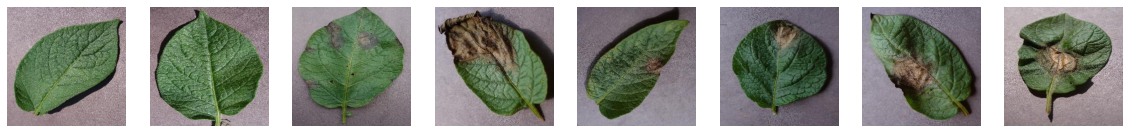

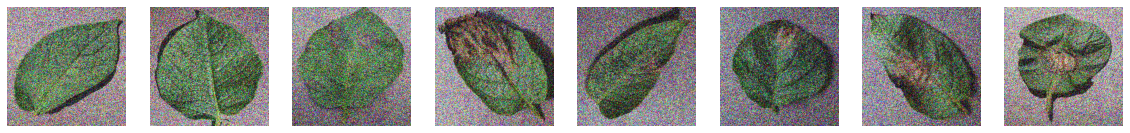

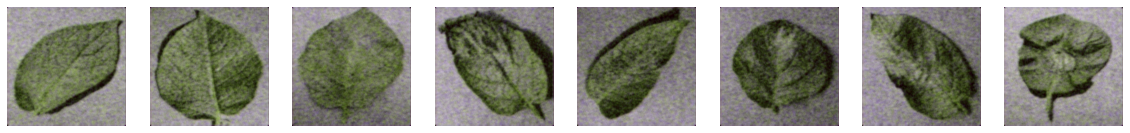

In [ ]:
denoised_paths, noised_paths, original_paths = getPaths('/content/Saved_Images', 'clean', 'denoised', 'noisy')
showImagesHorizontally(original_paths[:8])
showImagesHorizontally(noised_paths[:8])
showImagesHorizontally(denoised_paths[:8])

## **Stage 4:** Test the Model

### 4 Marks -> Evaluate model with the given test data

1. Extract only the images of test loader data as we do not use the labels for the autoencoder network
2. Pass the test images through the autoencoder model to get the denoised images of the test data. 
3. Calculate the loss of the test images

In [ ]:
def test_image_reconstruction(net, puretestloader, noisytestloader):
  running_loss = 0
  for clean, dirty in zip(puretestloader, noisytestloader):
    clean_images, labels = clean
    noisy_images, _ = dirty
    noisy_images, clean_images = noisy_images.to(device), clean_images.to(device)
    output = net(noisy_images)
    loss = criterion(output, clean_images)
    running_loss += loss.item()

    for i in range(len(output)):
        save_decoded_image(clean_images[i].cpu().data, name='./Saved_Images/test_clean{}.png'.format(i))
        save_decoded_image(output[i].cpu().data, name='./Saved_Images/test_denoised{}.png'.format(i))
        save_decoded_image(noisy_images[i].cpu().data, name='./Saved_Images/test_noised{}.png'.format(i))
  
  return running_loss/len(puretestloader)

In [ ]:
net.eval()
test_loss = test_image_reconstruction(net, pure_test_loader, noisy_test_loader)
print("Test Loss: ",test_loss)

Test Loss:  0.007118874706509636


### 3 Marks -> Visualizing and verifying test images with the original test noisy dataset

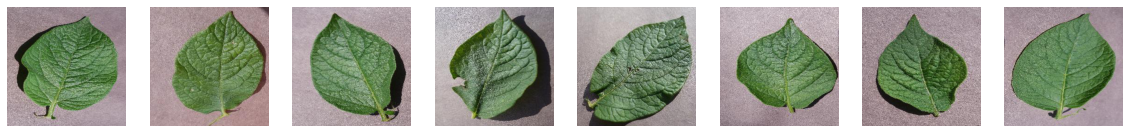

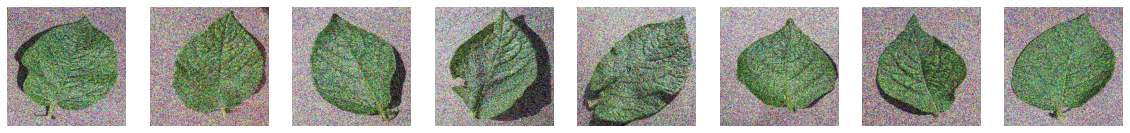

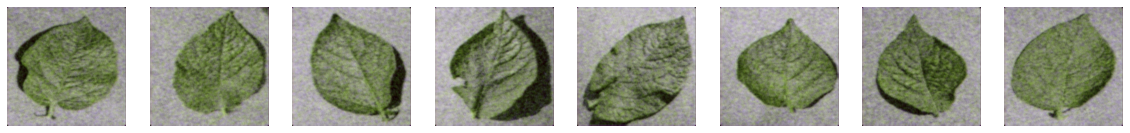

In [ ]:
# YOUR CODE HERE for verification and visualization of the test denoised images and original test noisy images

denoised_paths, noised_paths, original_paths = getPaths('/content/Saved_Images','test_clean', 'test_denoised', 'test_noised')
showImagesHorizontally(original_paths[:8])
showImagesHorizontally(noised_paths[:8])
showImagesHorizontally(denoised_paths[:8])